## Tools and Imports

In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import floor
import seaborn as sns
sns.set_style("darkgrid")

## Dataset

In [336]:
stockData = pd.read_csv("ML_datasets.csv")
stockData.head(8)

,Player,Team,Stat,Role,Best Attribute,Actual Result
0,1,1,1,0,0,1
1,2,1,1,1,1,1
2,3,1,0,2,0,1
3,4,1,0,3,2,1
4,5,2,1,0,0,0
5,6,2,0,3,1,0
6,7,2,1,5,0,0
7,8,2,0,1,1,0


## Basic EDA

before we can proceed to our Naive Bayes, we must confirm that the features we have are independent and are not correlated.

<AxesSubplot:>

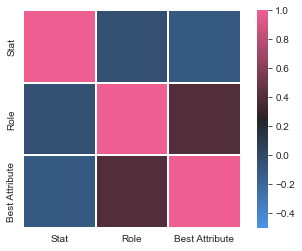

In [237]:
corr = stockData.iloc[:,2:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

## plotting of columns (ay lang ni apila)

<AxesSubplot:xlabel='Best Attribute', ylabel='Count'>

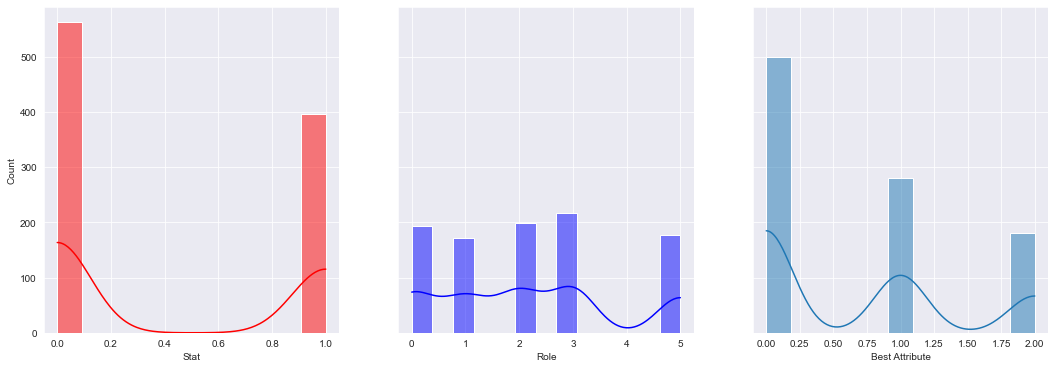

In [238]:
fig, axes = plt.subplots(1,3, figsize=(18,6), sharey=True)
sns.histplot(stockData, ax=axes[0], x="Stat", kde=True, color='r')
sns.histplot(stockData, ax=axes[1], x="Role", kde=True, color='b')
sns.histplot(stockData, ax=axes[2], x="Best Attribute", kde=True)

## Calculate Prior P(Y)
Logic for this would be P(Y) = totalY/totalN; Y = Win | Lose

In [313]:
def calculate_prior(training_d,Y):
    classes = sorted(list(training_d[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(training_d[training_d[Y]==i])/len(training_d))
    return prior

## Calculate P(X|Y) 
logic here is P(X|Y) = totalX/totalN; X = x0 | x1 | x2 (columns)

In [314]:
def calculate_likelihood(training_d, feat_name, feat_val, Y, label):
    training_d = training_d[training_d[Y]==label]
    p_x_given_y = len(training_d[training_d[feat_name]==feat_val]) / len(training_d)
    return p_x_given_y

## Calculate Probability P(X1|Y)P(X2|Y)P(X3|Y)...P(Xn|Y) * P(Y)

In [315]:
def naive_bayes_categorical(training_data, X, Y):
    #getting the feature names
    features = list(training_data.columns)[2:-1]
    
    prior = calculate_prior(training_data, Y)
    
    probW = []
    probL = []
    Ypred = []
    data = [[],[],[]]
    accumulatedP = [],[]
    for x in X:
        
        labels = sorted(list(training_data[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            #calculate P(X1|Y)P(X2|Y)P(X3|Y)...P(Xn|Y)
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood(training_data, features[i], x[i], Y, labels[j])
        post_prob = [1]*len(labels)
        
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]
               
    
        Ypred.append(np.argmax(post_prob))
        probW.append(post_prob[1])
        probL.append(post_prob[0])
    
    #Since there are 4 heroes per team, their probability are all multiplied
    for i in range(floor(len(X)/4)):
           accumulatedP[1].append(probW[i*4]*probW[(i*4)+1]*probW[(i*4)+2]*probW[(i*4)+3]) 
           accumulatedP[0].append(probL[i*4]*probL[(i*4)+1]*probL[(i*4)+2]*probL[(i*4)+3])
           if(accumulatedP[1][i] >= accumulatedP[0][i]):
               data[2].append(1)
           else:
               data[2].append(0)

    data[0] = accumulatedP[0]
    data[1] = accumulatedP[1]
    
    return data
        

## Testing For NB

In [335]:

from sklearn.model_selection import train_test_split
train, test = train_test_split(stockData, test_size=.3, shuffle=False)
X_test = test.iloc[:,2:-1].values
Y_test = test.iloc[:,-1].values

Ypred = naive_bayes_categorical(train, X=X_test, Y="Actual Result")

match_y =[]
for i in range(floor(len(X_test)/4)):
    match_y.append(Y_test[i*4])

result = pd.DataFrame({"Prediction":Ypred[2],"Win Probability": Ypred[1], "Lose Probability": Ypred[0],"Actual Result":match_y})

acc_init = np.sum(result["Prediction"] == result["Actual Result"]) / len(result["Actual Result"])
print(result)
print("Accuracy: ", acc_init)

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(result["Actual Result"], result["Prediction"]))
print("F-score: ", f1_score(result["Actual Result"], result["Prediction"]))


    Prediction  Win Probability  Lose Probability  Actual Result
0            1     1.708425e-07      1.041376e-07              1
1            0     1.536965e-07      2.066637e-07              0
2            1     2.543971e-07      1.581496e-07              1
3            0     1.584789e-07      1.625990e-07              0
4            1     3.580403e-08      3.006717e-08              1
..         ...              ...               ...            ...
67           0     9.672544e-08      1.323456e-07              1
68           0     2.798670e-07      3.113598e-07              1
69           0     7.494506e-08      8.859465e-08              0
70           0     5.844772e-08      7.106552e-08              0
71           0     7.036709e-08      7.118417e-08              1

[72 rows x 4 columns]
Accuracy:  0.6111111111111112
[[25 11]
 [17 19]]
F-score:  0.5757575757575758


## Adaboost

In [254]:
class DecisionStump:
    def __init__(self):
        self.polarity = 1
        self.feature_idx = None
        self.threshold = None
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1

        return predictions

In [326]:

class Adaboost:
    def __init__(self, n_clf=2):
        self.n_clf = n_clf
        self.clfs = []

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))

        self.clfs = []

        # Iterate through classifiers
        for _ in range(self.n_clf):
            clf = DecisionStump()
            min_error = float("inf")

            # greedy search to find best threshold and feature
            for feature_i in range(n_features):
                X_column = X[:, feature_i]
                thresholds = np.unique(X_column)

                for threshold in thresholds:
                    # predict with polarity 1
                    p = 1
                    predictions = np.ones(n_samples)
                    predictions[X_column < threshold] = -1

                    # Error = sum of weights of misclassified samples
                    misclassified = w[y != predictions]
                    error = sum(misclassified)

                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # store the best configuration
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
                        min_error = error

            # calculate alpha
            EPS = 1e-10
            clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS))

            # calculate predictions and update weights
            predictions = clf.predict(X)

            w *= np.exp(-clf.alpha * y * predictions)
            # Normalize to one
            w /= np.sum(w)

            # Save classifier
            self.clfs.append(clf)

    def predict(self, X):
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]
        y_pred = np.sum(clf_preds, axis=0)
        y_pred = np.sign(y_pred)

        return y_pred


## Data prep for AdaBoost Test

In [324]:

featuresNB = list(result.columns)[:-1]
win_rate = []
lose_rate = []
match_result = []

for i in range(floor(len(result)/2)):
    win_rate.append(result["Win Probability"][i*2]/(result["Win Probability"][i*2] + result["Win Probability"][(i*2)+1]))
    lose_rate.append(result["Lose Probability"][i*2]/(result["Lose Probability"][i*2] + result["Lose Probability"][(i*2)+1]))
    match_result.append(result["Actual Result"][i*2])


preAda = pd.DataFrame({"Win Probability":win_rate,"Lose Probability": lose_rate, "Actual Result": match_result})



print(preAda)

    
    

    Win Probability  Lose Probability  Actual Result
0          0.526416          0.335062              1
1          0.616159          0.493064              1
2          0.270159          0.185128              1
3          0.249819          0.310753              0
4          0.394286          0.505280              0
5          0.630952          0.547619              0
6          0.447059          0.397436              1
7          0.375718          0.237163              1
8          0.661872          0.578191              1
9          0.375349          0.555628              1
10         0.327203          0.200157              1
11         0.261817          0.359439              1
12         0.534483          0.443548              1
13         0.181538          0.287517              1
14         0.387535          0.400937              1
15         0.393997          0.293917              0
16         0.291476          0.217891              1
17         0.837712          0.737259         

## Training values for AdaBoost

In [329]:
X_train = train.iloc[:,2:-1].values
Y_train = train.iloc[:,-1].values

Ypred_train = naive_bayes_categorical(train, X=X_train, Y="Actual Result")
match_y_train =[]
for i in range(floor(len(X_train)/4)):
    match_y_train.append(Y_train[i*4])
    
train_result = pd.DataFrame({"Prediction":Ypred_train[2],"Win Probability": Ypred_train[1], "Lose Probability": Ypred_train[0],"Actual Result":match_y_train})

win_rate_train = []
lose_rate_train = []
match_result_train = []
for i in range(floor(len(train_result)/2)):
    win_rate_train.append(train_result["Win Probability"][i*2]/(train_result["Win Probability"][i*2] + train_result["Win Probability"][(i*2)+1]))
    lose_rate_train.append(train_result["Lose Probability"][i*2]/(train_result["Lose Probability"][i*2] + train_result["Lose Probability"][(i*2)+1]))
    match_result_train.append(train_result["Actual Result"][i*2])



preAda_train = pd.DataFrame({"Win Probability":win_rate_train,"Lose Probability": lose_rate_train, "Actual Result": match_result_train})

print(preAda_train)





    Win Probability  Lose Probability  Actual Result
0          0.518771          0.390414              1
1          0.314050          0.256198              1
2          0.644059          0.628517              0
3          0.729875          0.643965              1
4          0.853345          0.787316              1
..              ...               ...            ...
79         0.560933          0.705737              0
80         0.092524          0.193596              0
81         0.285617          0.425373              0
82         0.158284          0.278466              0
83         0.523222          0.320766              1

[84 rows x 3 columns]


# Testing for ada

In [328]:

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy


ada_train, ada_test = preAda_train, preAda

adaX_train = ada_train.iloc[:,:-1].values
aday_train = ada_train.iloc[:,2].values

aday_train[aday_train == 0] = -1

adaX_test = ada_test.iloc[:,:-1].values
aday_test = ada_test.iloc[:,2].values
aday_test[aday_test == 0] = -1

clf = Adaboost(n_clf=5)
clf.fit(adaX_train, aday_train)
y_pred = clf.predict(adaX_test)

acc = accuracy(aday_test, y_pred)
final_result = pd.DataFrame({"Win Probability":adaX_test[:,0],"Lose Probability": adaX_test[:,1],"Prediction": y_pred, "Actual Result": aday_test})
print(final_result)
print("Accuracy:", acc)


    Win Probability  Lose Probability  Prediction  Actual Result
0          0.526416          0.335062         1.0              1
1          0.616159          0.493064         1.0              1
2          0.270159          0.185128         1.0              1
3          0.249819          0.310753         1.0             -1
4          0.394286          0.505280         1.0             -1
5          0.630952          0.547619         1.0             -1
6          0.447059          0.397436         1.0              1
7          0.375718          0.237163         1.0              1
8          0.661872          0.578191         1.0              1
9          0.375349          0.555628        -1.0              1
10         0.327203          0.200157         1.0              1
11         0.261817          0.359439        -1.0              1
12         0.534483          0.443548         1.0              1
13         0.181538          0.287517        -1.0              1
14         0.387535      